In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys
sys.path.append('../')
sys.argv=[''] 
del sys

In [10]:
cd "/root/SymmNeRF/"

/root/SymmNeRF


In [11]:
from opt import config_parser
import torch 
import numpy as np 
import matplotlib.pyplot as plt 


parser = config_parser()
args = parser.parse_args()

device = torch.device("cuda:0")
det = args.det
lindisp = args.lindisp
args.distributed = False
args.local_feature_ch = 512
args.local_rank = 0
args.eval_scene = 'cars'
args.eval_dataset = 'srns_dataset'

args.no_load_opt = True
args.with_vit = True
args.archCNN = 'resnet18_light'
args.enforce_symmetry = {'status': False, 'on_coarse': False,'on_fine': False,'concatenate_on_coarse':False, 'concatenate_on_fine':False}

In [5]:
import setproctitle
setproctitle.setproctitle('[Gaetan - SymmNeRF VIT]')
from datasets import dataset_dict, create_training_dataset
from torch.utils.data import DataLoader 
from model.sample_ray import RaySampler

In [11]:
test_dataset = dataset_dict[args.eval_dataset](args, 'test', scene=args.eval_scene)
test_loader = DataLoader(test_dataset, batch_size=1)

SRNsDataset:  /data/datasets/srn_cars/cars_test


In [12]:
it = iter(test_loader)
test_batch = next(it)

In [13]:
ray_sampler = RaySampler(test_batch)

In [14]:
render_list = list(range(ray_sampler.render_imgs[0].shape[0]))
render_list.remove(ray_sampler.src_view[0])
render_view = np.random.choice(render_list, 1)[0]

It = ray_sampler.render_imgs[0][render_view].permute(1, 2, 0)
Is = ray_sampler.render_imgs[0][ray_sampler.src_view[0]].permute(1, 2, 0)

### Plot both any random source and target image. 

Text(0.5, 1.0, 'Target Image It')

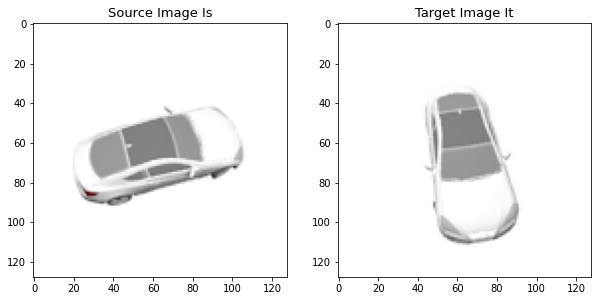

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(Is)
ax2.imshow(It)

ax1.set_title('Source Image Is', fontsize=13)
ax2.set_title('Target Image It', fontsize=13)

In [16]:
from model.projection import Projector 
from model.model import HyperNeRFResNetSymmLocal

model = HyperNeRFResNetSymmLocal(args,ckpts_folder = '')
projector = Projector(device)
model.switch_to_eval()

[Info] No ckpts found, training from scratch...


In [17]:
ray_batch = ray_sampler.random_sample(args.N_rand,device,use_bbox = True)

In [18]:
z,feat_cnn,feat_vit = model.encode(ray_batch['src_img'])

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [19]:
featmap = torch.cat([feat_cnn,feat_vit],1)

In [21]:
from model.render_ray import sample_along_camera_ray, sample_pdf,run_network,raw2outputs,render_single_image
from model.nerf import run_nerf_symm_local
from model.nerf_helpers import *
from utils.general import * 

In [22]:
rays_o = ray_batch['rays_o']    # [B,256,3]
rays_d = ray_batch['rays_d']    # [B,256,3]
z_near = ray_batch['z_near']
z_far = ray_batch['z_far'] 
    

# Get the points along the ray and symmetrize them with M. 
pts, viewdirs, z_vals = sample_along_camera_ray(rays_o=rays_o,  # pts : [B,256,64,3] - viewdirs : [B,256,3] - z_vals : [B,256,64]
                                                rays_d=rays_d,
                                                z_near=z_near,
                                                z_far=z_far,
                                                device=device,
                                                N_samples=args.N_samples, lindisp=args.lindisp, det=args.det)

# Get the Symmetric matrix. 
M = torch.tensor([[-1.,0.,0.],[0.,1.,0.],[0.,0.,1.]]).to(device)

# Predict the NeRF layers. 
nerf_coarse_layers = model.hypernetwork(z)

# Get the raw features. 
ret_features = projector.index(pts,ray_batch['src_pose'],ray_batch['intrinsics'], ray_batch['image_size'],M,featmap)

# Build up the final feature. 
f = ret_features['local_feature']
f_s = ret_features['local_feature_symm']
        
local_feature  = torch.cat([f,f_s],-1)
loc_feat_ch_coarse = local_feature.shape[-1]
nerf_coarse = lambda x: run_nerf_symm_local(x, 
                                            nerf_layers=nerf_coarse_layers, 
                                            input_ch=model.input_ch,
                                            input_ch_views=model.input_ch_views,
                                            local_feature_ch=loc_feat_ch_coarse)

raw_coarse = run_network(pts, viewdirs, nerf_coarse,
                                 model.embed_fn, model.embeddirs_fn, local_feature)
output_coarse = raw2outputs(raw_coarse,z_vals,ray_batch['rays_d'],device = device,raw_noise_std = False,white_bkgd = True)

In [23]:
pred = output_coarse['rgb']
gt = ray_batch['rgb']

In [ ]:
# Try to overfit the network over a single 

In [14]:
from opt import config_parser
import torch 
import numpy as np 
import matplotlib.pyplot as plt 


parser = config_parser()
args = parser.parse_args()

device = torch.device("cuda:0")
det = args.det
lindisp = args.lindisp
args.distributed = False
args.local_feature_ch = 512
args.local_rank = 1
args.eval_scene = 'cars'
args.eval_dataset = 'srns_dataset'

args.no_load_opt = True
args.expname = 'test_overfit'
args.with_vit = True
args.archCNN = 'resnet18_light'
args.enforce_symmetry = {'status': False, 'on_coarse': False,'on_fine': False,'concatenate_on_coarse':False, 'concatenate_on_fine':False}

[Info] Training dataset: srns_dataset
[Info] Set used: train
SRNsDataset:  /data/datasets/srn_cars/cars_train
[Info] No ckpts found, training from scratch...
[Info] Saving tensorboard files to /root/SymmNeRF/logs/srns_dataset/cars/test_overfit/tensorboard


  0%|          | 0/10000 [00:00<?, ?it/s]

test_overfit Epoch: 0 step: [0/300000]  loss: 0.518012 lr: 0.000100 train/coarse-loss: 0.293117 train/coarse-psnr-training-batch: 5.329568 train/fine-loss: 0.224895 train/fine-psnr-training-batch: 6.480184


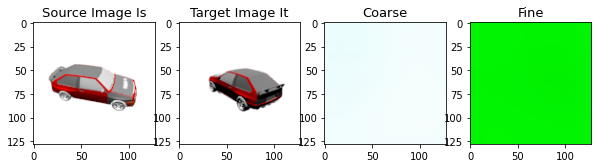

  3%|▎         | 251/10000 [01:03<39:36,  4.10it/s] 

test_overfit Epoch: 0 step: [250/300000]  loss: 0.043431 lr: 0.000100 train/coarse-loss: 0.020701 train/coarse-psnr-training-batch: 16.839880 train/fine-loss: 0.022730 train/fine-psnr-training-batch: 16.433842


  5%|▌         | 500/10000 [02:03<37:57,  4.17it/s]

test_overfit Epoch: 0 step: [500/300000]  loss: 0.036300 lr: 0.000100 train/coarse-loss: 0.018002 train/coarse-psnr-training-batch: 17.446431 train/fine-loss: 0.018297 train/fine-psnr-training-batch: 17.375913


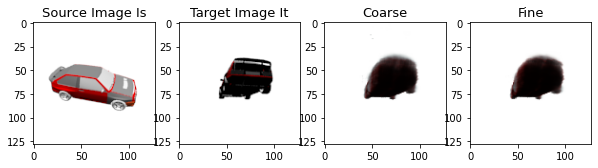

  8%|▊         | 751/10000 [03:07<37:24,  4.12it/s]  

test_overfit Epoch: 0 step: [750/300000]  loss: 0.034009 lr: 0.000100 train/coarse-loss: 0.015808 train/coarse-psnr-training-batch: 18.010895 train/fine-loss: 0.018201 train/fine-psnr-training-batch: 17.398843


 10%|█         | 1000/10000 [04:06<35:38,  4.21it/s]

test_overfit Epoch: 0 step: [1000/300000]  loss: 0.033272 lr: 0.000100 train/coarse-loss: 0.016135 train/coarse-psnr-training-batch: 17.922089 train/fine-loss: 0.017137 train/fine-psnr-training-batch: 17.660284


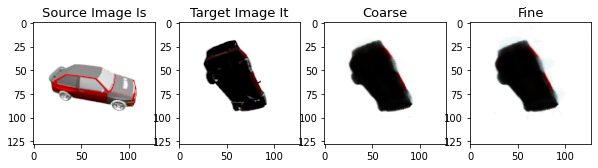

 13%|█▎        | 1251/10000 [05:09<35:02,  4.16it/s]  

test_overfit Epoch: 0 step: [1250/300000]  loss: 0.027346 lr: 0.000100 train/coarse-loss: 0.013160 train/coarse-psnr-training-batch: 18.807194 train/fine-loss: 0.014186 train/fine-psnr-training-batch: 18.481133


 15%|█▌        | 1500/10000 [06:08<33:49,  4.19it/s]

test_overfit Epoch: 0 step: [1500/300000]  loss: 0.021274 lr: 0.000100 train/coarse-loss: 0.010858 train/coarse-psnr-training-batch: 19.642146 train/fine-loss: 0.010416 train/fine-psnr-training-batch: 19.822536


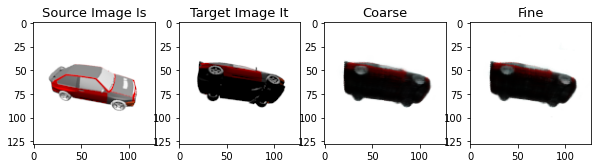

 18%|█▊        | 1751/10000 [07:11<33:20,  4.12it/s]  

test_overfit Epoch: 0 step: [1750/300000]  loss: 0.015518 lr: 0.000100 train/coarse-loss: 0.007433 train/coarse-psnr-training-batch: 21.287956 train/fine-loss: 0.008085 train/fine-psnr-training-batch: 20.922635


 20%|██        | 2000/10000 [08:10<31:32,  4.23it/s]

test_overfit Epoch: 0 step: [2000/300000]  loss: 0.013910 lr: 0.000100 train/coarse-loss: 0.006590 train/coarse-psnr-training-batch: 21.810311 train/fine-loss: 0.007319 train/fine-psnr-training-batch: 21.354706


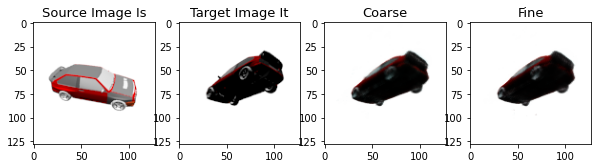

 23%|██▎       | 2251/10000 [09:14<31:09,  4.14it/s]  

test_overfit Epoch: 0 step: [2250/300000]  loss: 0.017485 lr: 0.000100 train/coarse-loss: 0.008852 train/coarse-psnr-training-batch: 20.528928 train/fine-loss: 0.008632 train/fine-psnr-training-batch: 20.638259


 25%|██▌       | 2500/10000 [10:13<29:28,  4.24it/s]

test_overfit Epoch: 0 step: [2500/300000]  loss: 0.021955 lr: 0.000100 train/coarse-loss: 0.010316 train/coarse-psnr-training-batch: 19.864291 train/fine-loss: 0.011638 train/fine-psnr-training-batch: 19.340733


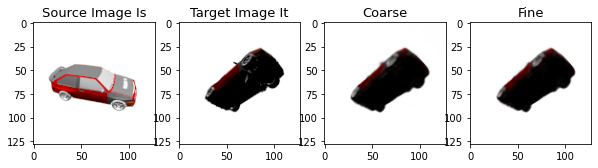

 28%|██▊       | 2751/10000 [11:34<57:33,  2.10it/s]  

test_overfit Epoch: 0 step: [2750/300000]  loss: 0.011376 lr: 0.000100 train/coarse-loss: 0.005837 train/coarse-psnr-training-batch: 22.337203 train/fine-loss: 0.005539 train/fine-psnr-training-batch: 22.564687


 30%|███       | 3000/10000 [13:30<54:19,  2.15it/s]

test_overfit Epoch: 0 step: [3000/300000]  loss: 0.011955 lr: 0.000100 train/coarse-loss: 0.006133 train/coarse-psnr-training-batch: 22.122219 train/fine-loss: 0.005821 train/fine-psnr-training-batch: 22.348925


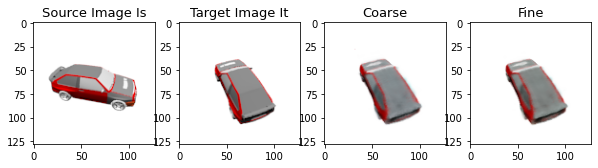

 33%|███▎      | 3251/10000 [15:33<53:07,  2.12it/s]  

test_overfit Epoch: 0 step: [3250/300000]  loss: 0.012402 lr: 0.000100 train/coarse-loss: 0.006610 train/coarse-psnr-training-batch: 21.797469 train/fine-loss: 0.005792 train/fine-psnr-training-batch: 22.371118


 35%|███▌      | 3500/10000 [17:28<50:20,  2.15it/s]

test_overfit Epoch: 0 step: [3500/300000]  loss: 0.024600 lr: 0.000100 train/coarse-loss: 0.010009 train/coarse-psnr-training-batch: 19.995796 train/fine-loss: 0.014591 train/fine-psnr-training-batch: 18.358758


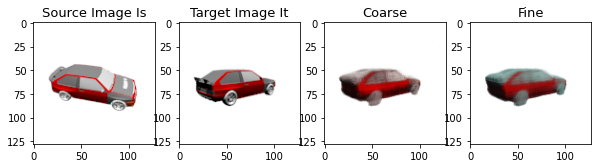

 38%|███▊      | 3751/10000 [19:31<47:20,  2.20it/s]  

test_overfit Epoch: 0 step: [3750/300000]  loss: 0.012838 lr: 0.000100 train/coarse-loss: 0.006484 train/coarse-psnr-training-batch: 21.880618 train/fine-loss: 0.006354 train/fine-psnr-training-batch: 21.969062


 40%|████      | 4000/10000 [21:27<46:00,  2.17it/s]

test_overfit Epoch: 0 step: [4000/300000]  loss: 0.015905 lr: 0.000100 train/coarse-loss: 0.007783 train/coarse-psnr-training-batch: 21.088162 train/fine-loss: 0.008122 train/fine-psnr-training-batch: 20.902915


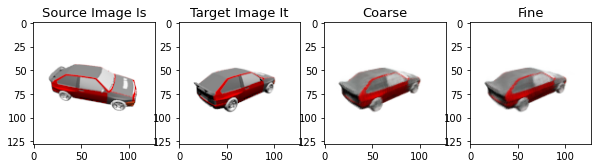

 43%|████▎     | 4251/10000 [23:30<45:35,  2.10it/s]  

test_overfit Epoch: 0 step: [4250/300000]  loss: 0.014373 lr: 0.000100 train/coarse-loss: 0.006904 train/coarse-psnr-training-batch: 21.608423 train/fine-loss: 0.007469 train/fine-psnr-training-batch: 21.266689


 45%|████▌     | 4500/10000 [25:21<42:45,  2.14it/s]

test_overfit Epoch: 0 step: [4500/300000]  loss: 0.009855 lr: 0.000100 train/coarse-loss: 0.005007 train/coarse-psnr-training-batch: 23.003482 train/fine-loss: 0.004848 train/fine-psnr-training-batch: 23.143094


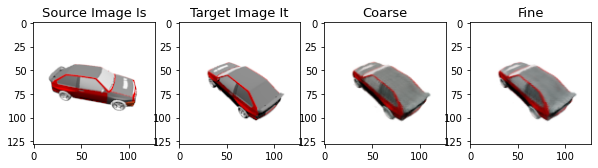

 48%|████▊     | 4751/10000 [27:25<41:37,  2.10it/s]  

test_overfit Epoch: 0 step: [4750/300000]  loss: 0.014597 lr: 0.000100 train/coarse-loss: 0.006979 train/coarse-psnr-training-batch: 21.561189 train/fine-loss: 0.007618 train/fine-psnr-training-batch: 21.181053


 50%|█████     | 5000/10000 [29:19<38:34,  2.16it/s]

test_overfit Epoch: 0 step: [5000/300000]  loss: 0.010652 lr: 0.000100 train/coarse-loss: 0.005156 train/coarse-psnr-training-batch: 22.876131 train/fine-loss: 0.005496 train/fine-psnr-training-batch: 22.598455


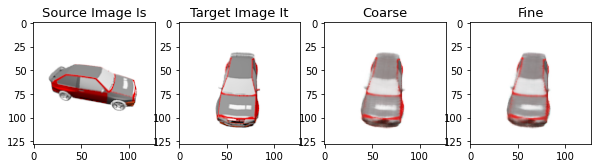

 51%|█████     | 5120/10000 [30:21<28:56,  2.81it/s]  


KeyboardInterrupt: 

In [15]:
import time
import imageio
import shutil
import torch.distributed as dist
import torch.utils.data.distributed
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import random


from utils.general import *
from datasets import dataset_dict, create_training_dataset
from model import model_dict
from model.projection import Projector
from model.sample_ray import RaySampler
from model.render_ray import  log_view_to_tb, render_rays
import setproctitle
import tqdm 
setproctitle.setproctitle('[SymmNeRF - with ViT]')

device = "cuda:{}".format(args.local_rank) if args.local_rank >= 0 else "cpu"

logs_folder = os.path.join('/root/SymmNeRF/logs', args.train_dataset, args.train_scene, args.expname)
  
os.makedirs(logs_folder, exist_ok=True)

ckpts_folder = os.path.join(logs_folder, 'ckpts')
os.makedirs(ckpts_folder, exist_ok=True)

visuals_folder = os.path.join(logs_folder, 'visuals')
os.makedirs(os.path.join(visuals_folder, 'train'), exist_ok=True)
os.makedirs(os.path.join(visuals_folder, 'val'), exist_ok=True)
    
# Save the args and config files
f = os.path.join(logs_folder, 'args.txt')

# Create training dataset
train_dataset, train_sampler = create_training_dataset(args)
train_loader = DataLoader(train_dataset, batch_size= 1,#args.batch_size,
                              worker_init_fn=lambda _: np.random.seed(),
                              num_workers=args.workers,
                              pin_memory=False,
                              sampler=train_sampler,
                              shuffle=True if train_sampler is None else False)


# Create model
model = model_dict[args.model](args, ckpts_folder)

# Create the projector
projector = Projector(device)
    
# Create criterion
criterion = torch.nn.MSELoss()

tb_dir = os.path.join(logs_folder, 'tensorboard')
writer = SummaryWriter(tb_dir)
print('[Info] Saving tensorboard files to {}'.format(tb_dir))

scalars_to_log = {}
global_step = model.start_step + 1
epoch = 0

M = torch.tensor([[-1.,0.0, 0.0],[0.0, 1.0, 0.0],[0.0, 0.0, 1.0]]).to(device)
    
    
    
it = iter(train_loader)
train_data = next(it)

# Load training rays
ray_sampler = RaySampler(train_data)
    
for global_step in tqdm.tqdm(range(10000)):
       
        
    ray_batch = ray_sampler.random_sample(args.N_rand,device, use_bbox=(global_step <= args.no_bbox_step))

    z,feat_cnn,feat_vit = model.encode(ray_batch['src_img'])
            
    # Feature concatenation.
    featmap = feat_cnn if feat_vit is None else torch.cat([feat_cnn,feat_vit],1)
           
    ret = render_rays(ray_batch = ray_batch,
                          model = model,
                          device = device,
                          featmap = featmap,
                          latent_vector = z,
                          projector = projector,
                          N_samples = args.N_samples,
                          M = M, 
                          enforceSymm = args.enforce_symmetry,
                          lindisp = args.lindisp,
                          N_importance = args.N_importance,
                          det = args.det,
                          raw_noise_std = args.raw_noise_std,
                          white_bkgd = args.white_bkgd)
            
    # Compute loss
    model.optimizer.zero_grad()
    # Add the constraint only on the coarse model for now. 
    loss = criterion(ret['outputs_coarse']['rgb'], ray_batch['rgb']) #+ \
    
    if ret['outputs_fine'] is not None:
        fine_loss = criterion(ret['outputs_fine']['rgb'], ray_batch['rgb'])
        loss += fine_loss
                  
    loss.backward()
    scalars_to_log['loss'] = loss.item()
    model.optimizer.step()
    # model.scheduler.step()
    #if hasattr(model, 'warmup_scheduler'):
        #model.scheduler.step(model.scheduler.last_epoch + 1)
        #model.warmup_scheduler.dampen()
   # else:
        #model.scheduler.step()

    # scalars_to_log['lr'] = model.scheduler.get_last_lr()[0]
    scalars_to_log['lr'] = model.optimizer.param_groups[0]['lr']

    # Rest is logging
    if global_step % 250 == 0:
        # Write mse and psnr stats
        mse_error = img2mse(ret['outputs_coarse']['rgb'], ray_batch['rgb']).item()
        scalars_to_log['train/coarse-loss'] = mse_error
        scalars_to_log['train/coarse-psnr-training-batch'] = mse2psnr(mse_error)
        if ret['outputs_fine'] is not None:
            mse_error = img2mse(ret['outputs_fine']['rgb'], ray_batch['rgb']).item()
            scalars_to_log['train/fine-loss'] = mse_error
            scalars_to_log['train/fine-psnr-training-batch'] = mse2psnr(mse_error)

        logstr = '{} Epoch: {} step: [{}/{}] '.format(args.expname, epoch, global_step, args.N_iters)
        for k in scalars_to_log.keys():
            logstr += ' {}: {:.6f}'.format(k, scalars_to_log[k])
            writer.add_scalar(k, scalars_to_log[k], global_step)
        print(logstr)

        if global_step % 500 == 0:
            

            render_list = list(range(ray_sampler.render_imgs[0].shape[0]))
            render_list.remove(ray_sampler.src_view[0])
            render_view = np.random.choice(render_list, 1)[0]

            gt_img = ray_sampler.render_imgs[0][render_view].permute(1, 2, 0)
            src_img = ray_sampler.render_imgs[0][ray_sampler.src_view[0]].permute(1,2,0)

            rgb_im, depth_im, acc_map = log_view_to_tb(writer, global_step, args, model,projector,M, device,
                                                               ray_sampler, render_view,
                                                               gt_img, prefix='train/')
               
                        
            rgb_img = rgb_im.permute(1,2,0)
            It = gt_img.numpy()
            Is = src_img.numpy()
            Icoarse = rgb_img.numpy()[:,256:384,:]
            Ifine = rgb_img.numpy()[:,384:512,:]
            
            #print(f'Mean of Icoarse: {np.mean(Icoarse, axis=(0, 1))} - any random value: {Icoarse[np.random.randint(128),np.random.randint(128),:3]}')
            #print(f'Mean of Ifine: {np.mean(Ifine,axis=(0,1))} - any random value: {Ifine[np.random.randint(128),np.random.randint(128),:3]}')


            import matplotlib.pyplot as plt 

            fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 10))

            ax1.imshow(Is)
            ax2.imshow(It)
            ax3.imshow(Icoarse)
            ax4.imshow(Ifine)
            
            ax1.set_title('Source Image Is', fontsize=13)
            ax2.set_title('Target Image It', fontsize=13)
            ax3.set_title('Coarse', fontsize=13)
            ax4.set_title('Fine',fontsize=13)
            
            plt.show()
            
            torch.cuda.empty_cache()
      


In [7]:
import time
import imageio
import shutil
import torch.distributed as dist
import torch.utils.data.distributed
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import random


from utils.general import *
from datasets import dataset_dict, create_training_dataset
from model import model_dict
from model.projection import Projector
from model.sample_ray import RaySampler
from model.render_ray import  log_view_to_tb, render_rays
import setproctitle
import tqdm 
setproctitle.setproctitle('[SymmNeRF - Train Baseline]')

device = "cuda:{}".format(args.local_rank) if args.local_rank >= 0 else "cpu"

logs_folder = os.path.join('/root/SymmNeRF/logs', args.train_dataset, args.train_scene, args.expname)
  
os.makedirs(logs_folder, exist_ok=True)

ckpts_folder = os.path.join(logs_folder, 'ckpts')
os.makedirs(ckpts_folder, exist_ok=True)

visuals_folder = os.path.join(logs_folder, 'visuals')
os.makedirs(os.path.join(visuals_folder, 'train'), exist_ok=True)
os.makedirs(os.path.join(visuals_folder, 'val'), exist_ok=True)
    
# Save the args and config files
f = os.path.join(logs_folder, 'args.txt')

# Create training dataset
train_dataset, train_sampler = create_training_dataset(args)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                              worker_init_fn=lambda _: np.random.seed(),
                              num_workers=args.workers,
                              pin_memory=False,
                              sampler=train_sampler,
                              shuffle=True if train_sampler is None else False)


# Create model
model = model_dict[args.model](args, ckpts_folder)

# Create the projector
projector = Projector(device)
    
# Create criterion
criterion = torch.nn.MSELoss()

tb_dir = os.path.join(logs_folder, 'tensorboard')
writer = SummaryWriter(tb_dir)
print('[Info] Saving tensorboard files to {}'.format(tb_dir))

M = torch.tensor([[-1.,0.0, 0.0],[0.0, 1.0, 0.0],[0.0, 0.0, 1.0]]).to(device)

[Info] Training dataset: srns_dataset
[Info] Set used: train
SRNsDataset:  /data/datasets/srn_cars/cars_train
go there ?
[Info] No ckpts found, training from scratch...
[Info] Saving tensorboard files to /root/SymmNeRF/logs/srns_dataset/cars/with_vit/tensorboard


In [31]:
it = iter(train_loader)
train_data = next(it)

# Load training rays
ray_sampler = RaySampler(train_data)

            

render_list = list(range(ray_sampler.render_imgs[0].shape[0]))
render_list.remove(ray_sampler.src_view[0])
render_view = np.random.choice(render_list, 1)[0]

gt_img = ray_sampler.render_imgs[0][render_view].permute(1, 2, 0)
src_img = ray_sampler.render_imgs[0][ray_sampler.src_view[0]].permute(1,2,0)

rgb_im, depth_im, acc_map = log_view_to_tb(writer, global_step, args, model,projector,M, device,
                                                               ray_sampler, render_view,
                                                               gt_img, prefix='train/')

rgb_img = rgb_im.permute(1,2,0)
               
                        
torch.cuda.empty_cache()
      




In [32]:
It = gt_img.numpy()
Is = src_img.numpy()
Ipred = rgb_img.numpy()[:,256:384,:]
print(It.shape,Is.shape,Ipred.shape)

(128, 128, 3) (128, 128, 3) (128, 128, 3)


Text(0.5, 1.0, 'All It')

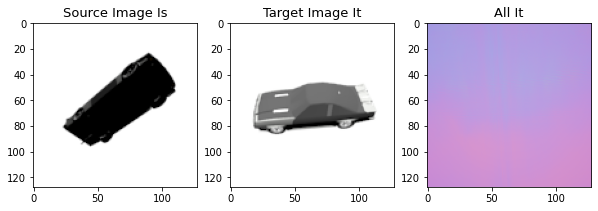

In [33]:
import matplotlib.pyplot as plt 

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 10))

ax1.imshow(Is)
ax2.imshow(It)
ax3.imshow(Ipred)
ax1.set_title('Source Image Is', fontsize=13)
ax2.set_title('Target Image It', fontsize=13)
ax3.set_title('All It', fontsize=13)

In [34]:
print(np.max(Ipred))
print(np.min(Ipred))

print(np.max(Is))
print(np.max(It))

0.8956673
0.54118663
1.0
1.0


In [ ]:
imageio.imwrite(os.path.join(visuals_folder, 'train',
                                                     'rgb_src-gt-coarse-fine_{}.png'.format(global_step)),
                                        to8b(np.array(rgb_im.permute(1, 2, 0))))
            imageio.imwrite(os.path.join(visuals_folder, 'train',
                                                     'depth-coarse-fine_{}.png'.format(global_step)),
                                        to8b(np.array(depth_im.permute(1, 2, 0))))
            imageio.imwrite(os.path.join(visuals_folder, 'train',
                                                     'acc-coarse-fine_{}.png'.format(global_step)),
                                        to8b(np.array(acc_map.permute(1, 2, 0))))
            print('Images saved !')